### Dataset Oxford-IIIT Pet

https://www.robots.ox.ac.uk/~vgg/data/pets/

O conjunto de dados contém fotografias de cães e gatos com 37 categorias, contendo aproximadamente 200 imagens para cada classe. As imagens apresentam grande variação em escala, pose e iluminação. Todas as imagens possuem anotações de referência (ground truth) associadas, incluindo raça, região de interesse (ROI) da cabeça e segmentação trimap em nível de pixel.

### Exemplos de anotações

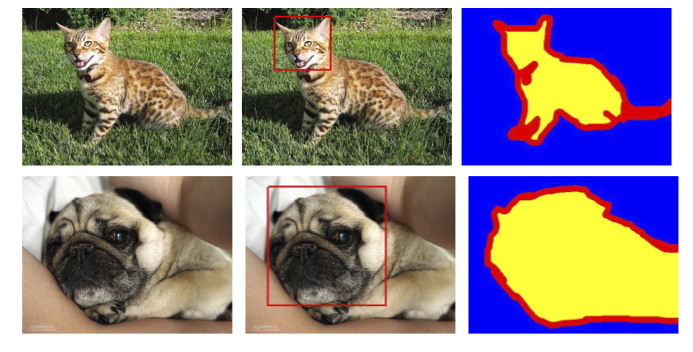

### Bibliotecas

In [63]:
import os
import tarfile
import warnings
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings('ignore')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Hardware utilizado: {DEVICE}')

Hardware utilizado: cuda


### Carregar dataset

Aqui é o momento de sofrimento. Preparar e organizar um conjunto de imagens e máscaras para que o modelo aprenda.

1. Classe `OxfordPetSegmentation`
- É uma estrutura que lê os arquivos compactados (tar.gz) com:
    - Imagens de animais (gatos e cachorros)
    - Máscaras/anotações que mostram qual parte da imagem é o animal e qual é o fundo.
- O código extrai esses arquivos se ainda não estiverem descompactados.
- Depois ele organiza os pares (imagem + máscara correspondente).
- Cada imagem é redimensionada (para 128x128 pixels) e convertida em tensores, que são o formato que a IA entende.
- As máscaras são transformadas em formatos numéricos (por exemplo, 0 = fundo, 1 = animal, 2 = contorno).

Resultado: cada item que o modelo recebe é um par: (imagem processada, máscara indicando onde está o animal)

2. Função `create_dataloaders`

- Divide os dados em três partes:
    - 80% para treinamento
    - 10% para validação
    - 10% para teste.
- Cria os dataloaders

3. Classe `CustomReducedDataset`
- Serve para criar um conjunto menor com as imagens e os rótulos já prontos.
- Transforma dados do tipo NumPy em tensores usados pelo PyTorch.

4. Função `get_full_train_data`
- Percorre todo o conjunto de treinamento e junta todas as imagens e máscaras em grandes blocos de dados.
- Converte as máscaras de formato “one-hot” (usado no treinamento) para formato de índice simples (ex: 0, 1, 2).
- Retorna os dados tanto em formato PyTorch (para o modelo) quanto NumPy (para análises).

In [64]:
class OxfordPetSegmentation(Dataset):
    def __init__(
        self, images_tar, annotations_tar, extract_dir='data/pets/',
        input_size=(128, 128), num_classes=3, augment=False, limit=None
    ):
        self.input_size = input_size
        self.num_classes = num_classes
        self.augment = augment

        os.makedirs(extract_dir, exist_ok=True)
        self.images_dir = os.path.join(extract_dir, 'images')
        self.ann_dir = os.path.join(extract_dir, 'annotations', 'trimaps')

        if not os.path.exists(self.images_dir) and os.path.exists(images_tar):
             with tarfile.open(images_tar, 'r:gz') as tar:
                 print('Iniciando extração das imagens...')
                 tar.extractall(extract_dir)

        if not os.path.exists(self.ann_dir) and os.path.exists(annotations_tar):
             with tarfile.open(annotations_tar, 'r:gz') as tar:
                 print('Iniciando extração das anotações...')
                 tar.extractall(extract_dir)
        
        self.image_files = sorted([f for f in os.listdir(self.images_dir) if f.endswith('.jpg') and not f.startswith('._')])
        self.ann_files = sorted([f for f in os.listdir(self.ann_dir) if f.endswith('.png') and not f.startswith('._')])
        
        base_names = [os.path.splitext(f)[0] for f in self.image_files]
        ann_base_names = [os.path.splitext(f)[0] for f in self.ann_files]

        valid_base_names = set(base_names).intersection(set(ann_base_names))
        
        self.image_files = sorted([f for f in self.image_files if os.path.splitext(f)[0] in valid_base_names])
        self.ann_files = sorted([f for f in self.ann_files if os.path.splitext(f)[0] in valid_base_names])

        if limit:
            self.image_files = self.image_files[:limit]
            self.ann_files = self.ann_files[:limit]

        self.image_transform = transforms.Compose([
            transforms.Resize(self.input_size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
        ])
        self.mask_resize = transforms.Resize(self.input_size, interpolation=transforms.InterpolationMode.NEAREST)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        ann_name = os.path.splitext(img_name)[0] + '.png'
        img_path = os.path.join(self.images_dir, img_name)
        ann_path = os.path.join(self.ann_dir, ann_name)

        try:
            img = Image.open(img_path).convert('RGB')
            mask = Image.open(ann_path)
        except Exception as e:
            print(f'Erro ao carregar máscara: {e}. Pulando.')
            return self.__getitem__((idx + 1) % len(self))

        img = self.image_transform(img)
        mask = self.mask_resize(mask)
        mask = np.array(mask, dtype=np.uint8)

        mask_mapped = np.zeros_like(mask, dtype=np.uint8)
        mask_mapped[mask == 3] = 0
        mask_mapped[mask == 1] = 1
        mask_mapped[mask == 2] = 2

        mask = torch.from_numpy(mask_mapped).long()
        mask_onehot = torch.nn.functional.one_hot(mask, num_classes=self.num_classes)
        mask_onehot = mask_onehot.permute(2, 0, 1).float()

        return img, mask_onehot

def create_dataloaders(
    images_tar, annotations_tar, extract_dir,
    input_size=(128, 128), num_classes=3,
    batch_size=8, augment=True, limit=None
):
    dataset = OxfordPetSegmentation(
        images_tar, annotations_tar, extract_dir,
        input_size=input_size, num_classes=num_classes,
        augment=augment, limit=limit
    )

    total = len(dataset)
    train_len = int(total * 0.8)
    val_len = int(total * 0.1)
    test_len = total - train_len - val_len
    
    if train_len == 0 or val_len == 0:
        raise ValueError('Dataset muito pequeno para split (mínimo 20 amostras). Aumente o limite.')
        
    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    print(f'Dataset: {total} imagens ({train_len} treino, {val_len} val, {test_len} teste)')
    return train_loader, val_loader, test_loader

class CustomReducedDataset(Dataset):
    def __init__(self, images_np, labels_index_np):
        self.images = torch.from_numpy(images_np).float().permute(0, 3, 1, 2)
        self.labels = torch.from_numpy(labels_index_np).long()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
    
@torch.no_grad()
def get_full_train_data(dataloader, device):
    all_images = []
    all_masks_index = []
    
    for images, masks_onehot in dataloader:
        all_images.append(images)
        masks_index = torch.argmax(masks_onehot, dim=1) 
        all_masks_index.append(masks_index)
        
    X_train_orig_tensor = torch.cat(all_images, dim=0).to(device)
    y_train_seg_index_tensor = torch.cat(all_masks_index, dim=0).to(device)
    
    X_train_orig_np = X_train_orig_tensor.permute(0, 2, 3, 1).cpu().numpy()
    y_train_seg_index_np = y_train_seg_index_tensor.cpu().numpy()
    
    return X_train_orig_tensor, y_train_seg_index_tensor, X_train_orig_np, y_train_seg_index_np

### Modelo

1. Função `conv_block`
- Cria um pequeno bloco de processamento de imagem, que aplica duas camadas de convolução
- Após cada convolução, aplica uma função de ativação (ReLU), que ajuda o modelo no aprendizado das relações não lineares. (filtro para detalhes)

2. Classe `UNet`
- Monta a arquitetura completa da rede U-Net, formada por duas partes principais:
- Encoder (comprime): reduz a imagem e extrai as informações mais importantes (como o que é fundo e o que é objeto).
- Decoder (reconstrói): usa essas informações para reconstruir uma imagem segmentada, mostrando onde está cada elemento.
- Durante esse processo, ela usa:
    - Camadas de convolução para aprender padrões.
    - Camadas de pooling para reduzir a imagem e simplificar o conteúdo.
    - Camadas de upsampling para ampliar a imagem novamente e gerar o resultado final.
    - “Conexões em skip” (junção das partes do encoder com o decoder) para preservar detalhes finos.

Pelo que entendi, é como se a rede “visse a imagem em baixa resolução para entender o todo” e depois “reconstruísse com detalhes”, marcando cada região.

In [66]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super(UNet, self).__init__()
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = conv_block(64, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = conv_block(64, 32)
        self.out = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        b = self.bottleneck(p2)
        u2 = self.upconv2(b)
        d2 = self.dec2(torch.cat((u2, e2), dim=1))
        u1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat((u1, e1), dim=1))
        
        return self.out(d1)

### Geração do Mapa de Saliência

1. Função `create_saliency_mask`
- Recebe a previsão da rede neural, que são as probabilidades de cada pixel pertencer a uma classe
- Calcula quais pixels são mais relevantes
- Cria uma máscara binária (1 = importante, 0 = irrelevante) com base num percentual de corte
- Essa máscara é usada para marcar visualmente o que o modelo considerou importante na imagem

2. Função `apply_mask`
- Usa a máscara para zerar (escurecer) as partes da imagem que não são relevantes.
- O resultado é uma imagem onde só as áreas importantes permanecem visíveis.

In [67]:
@torch.no_grad()
def create_saliency_mask(predictions, threshold_percentile=90):
    probabilities = F.softmax(predictions, dim=1)
    relevance_scores = torch.sum(probabilities[:, 1:, :, :], dim=1) 
    masks = []
    
    for scores in relevance_scores:
        flat_scores = scores.flatten()
        k_index = int(len(flat_scores) * (1 - threshold_percentile / 100.0))
        k_index = max(0, min(k_index, len(flat_scores) - 1))
        threshold_value = torch.kthvalue(flat_scores, k_index + 1).values.item()
        
        mask = (scores >= threshold_value).float()
        masks.append(mask.unsqueeze(0))
    
    masks_tensor = torch.stack(masks).to(DEVICE)
    return masks_tensor

def apply_mask(images, masks):
    return images * masks

### Métricas de Segmentação

1. Função `calculate_metrics`
- Entrada:
    - As previsões da rede (o que o modelo “classificou” para que é cada pixel)
    - As respostas verdadeiras (o que realmente é cada pixel)
    - O número de classes
- Para cada classe (exceto o fundo), compara o que foi previsto vs. o que era correto e calcula duas métricas:
    - IoU (Interseção sobre União) → mede quanto a área prevista e a real se sobrepõem.
    - Dice → mede o quanto as duas áreas são parecidas, penalizando diferenças menores.

Ambas as métricas vão de 0 a 1, quanto mais perto de 1, melhor a precisão da segmentação do modelo.

In [68]:
def calculate_metrics(predictions, targets_index, num_classes):
    preds = torch.argmax(predictions, dim=1) 
    
    iou_list = []
    dice_list = []
    
    for cls in range(1, num_classes): 
        pred_mask = (preds == cls)
        target_mask = (targets_index == cls)
        
        pred_mask_f = pred_mask.float()
        target_mask_f = target_mask.float()
        
        intersection = torch.sum(pred_mask_f * target_mask_f)
        union = torch.sum(pred_mask_f) + torch.sum(target_mask_f) - intersection
        
        iou = intersection / (union + 1e-6)
        iou_list.append(iou.item())
        
        dice = (2. * intersection) / (torch.sum(pred_mask_f) + torch.sum(target_mask_f) + 1e-6)
        dice_list.append(dice.item())

    return np.mean(iou_list), np.mean(dice_list)

### Treino

1. Função `train_iteration`
- Entrada:
    - Modelo UNet
    - Os dados de treino e validação
    - O otimizador (ajusta os pesos da rede)
    - Função de perda
    - Número de épocas

2. Durante o treinamento
- Para cada imagem:
    - O modelo faz uma previsão (qual pixel pertence a qual classe).
    - O código calcula o quanto a previsão errou.
    - O modelo ajusta seus parâmetros para reduzir a perda (processo de aprendizado).
    - A cada época, calcula-se a média da perda.
    - Um ajustador automático da taxa de aprendizado (scheduler) reduz o ritmo de aprendizado se o modelo parar de melhorar, isso ajuda a evitar que o modelo “desaprenda”. (que termo de merda eu usei...)

3. Após o treinamento
- O modelo é testado com o conjunto de validação, que ele ainda não viu.
- São calculadas as métricas de desempenho:
- mIoU e mDice → indicam quão bem o modelo identificou as regiões certas da imagem.

"Quanto mais altos esses valores, melhor o modelo está segmentando as imagens." Nem tudo devemos levar a ferro e fogo

In [69]:
def train_iteration(model, dataloader, val_dataloader, optimizer, criterion, num_classes, epochs=60):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )
    
    model.train()
    print(f" > Treinando por {epochs} épocas...")
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        scheduler.step(avg_loss) 
        
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  Época {epoch+1}/{epochs}, Perda Média: {avg_loss:.4f}, LR: {current_lr:.6f}")

    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            all_preds.append(outputs)
            all_targets.append(labels)

    final_predictions = torch.cat(all_preds, dim=0)
    final_targets = torch.cat(all_targets, dim=0)

    final_targets_index = torch.argmax(final_targets, dim=1)
    
    m_iou, m_dice = calculate_metrics(final_predictions, final_targets_index, num_classes)
    print(f" > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = {m_iou:.4f}, mDice = {m_dice:.4f}")
    
    return model, m_iou, m_dice

In [72]:
def visualize_saliency_and_reduction(original_img_np, mask_tensor, reduced_img_np, iteration):
    mask_np = mask_tensor[0].squeeze(0).cpu().numpy()
    original_img_np = original_img_np[0].transpose(1, 0, 2).clip(0, 1)
    reduced_img_np = reduced_img_np[0].transpose(1, 0, 2).clip(0, 1)
    
    current_threshold = 70 + (iteration - 1) * 5

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Iteração {iteration}: Visualização da Redução Espacial (Top {current_threshold}%)", fontsize=16)

    axes[0].imshow(original_img_np)
    axes[0].set_title("1. Imagem Original")
    axes[0].axis('off')

    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title("2. Máscara de Saliência (Relevante=Branco)")
    axes[1].axis('off')

    axes[2].imshow(reduced_img_np)
    axes[2].set_title("3. Imagem Reduzida (Pixels não-relevantes zerados)")
    axes[2].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### MAIN

Dataset: 1000 imagens (800 treino, 100 val, 100 teste)

Iniciando Treinamento Iterativo (Max. 15 iterações) no cuda.

--- Iteração 1 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.8110, LR: 0.000100
  Época 10/30, Perda Média: 0.7680, LR: 0.000100
  Época 15/30, Perda Média: 0.7332, LR: 0.000100
  Época 20/30, Perda Média: 0.6960, LR: 0.000100
  Época 25/30, Perda Média: 0.6350, LR: 0.000100
  Época 30/30, Perda Média: 0.6051, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.6609, mDice = 0.7940
 > Gerando máscara de saliência (Top 70% dos pixels relevantes).


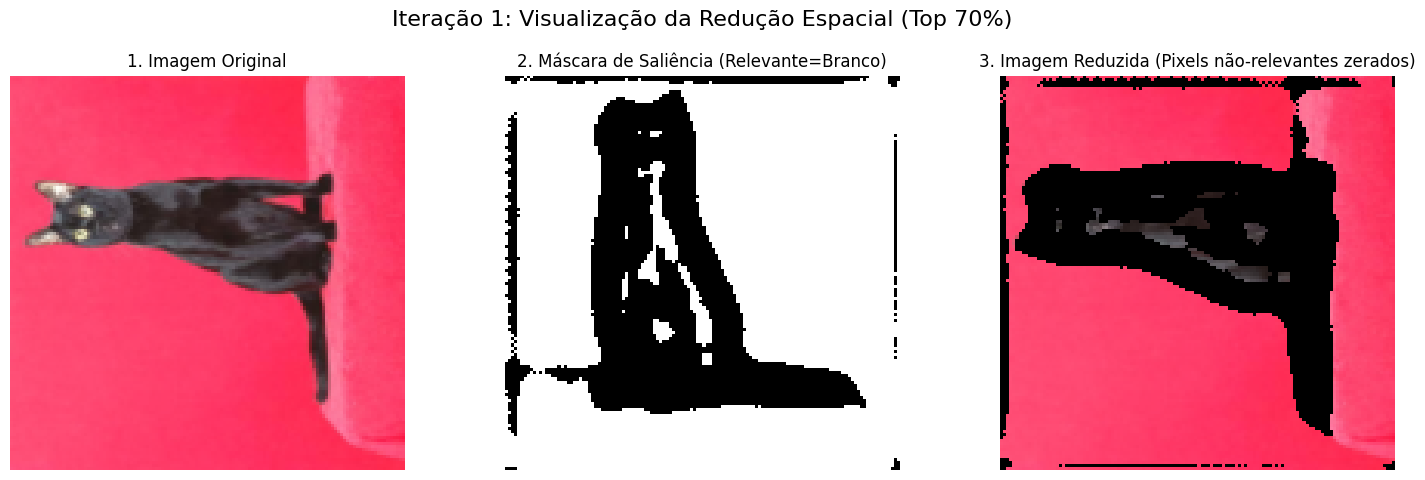

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 2.
--- Iteração 2 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.6293, LR: 0.000100
  Época 10/30, Perda Média: 0.6037, LR: 0.000100
  Época 15/30, Perda Média: 0.5941, LR: 0.000100
  Época 20/30, Perda Média: 0.6005, LR: 0.000100
  Época 25/30, Perda Média: 0.5655, LR: 0.000100
  Época 30/30, Perda Média: 0.5597, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.6413, mDice = 0.7802
 > Gerando máscara de saliência (Top 75% dos pixels relevantes).


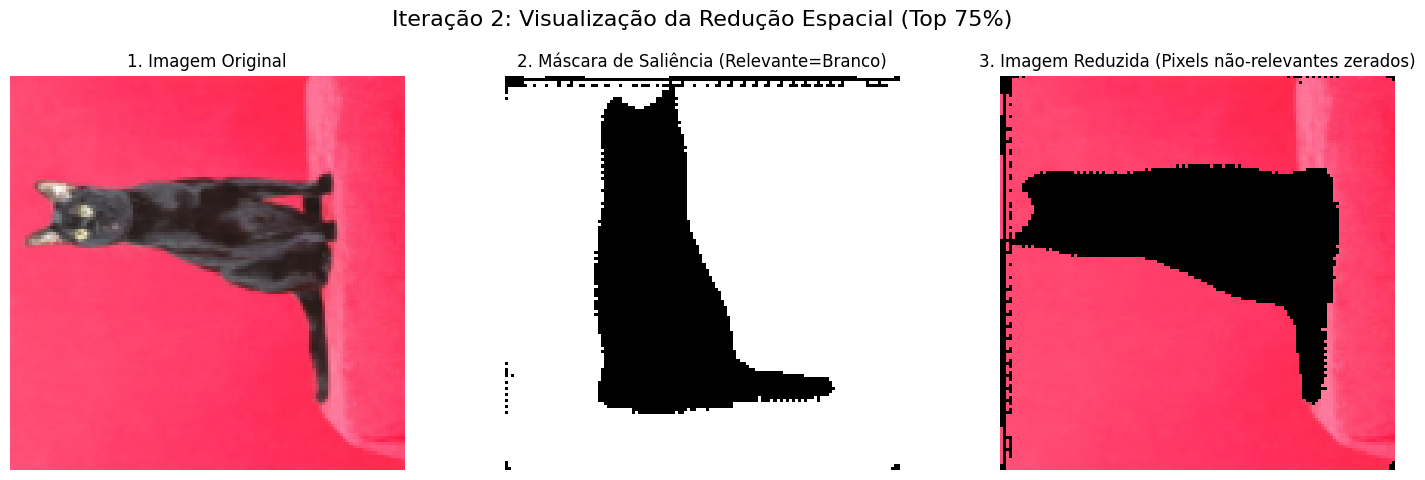

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 3.
--- Iteração 3 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.5611, LR: 0.000100
  Época 10/30, Perda Média: 0.5550, LR: 0.000100
  Época 15/30, Perda Média: 0.5381, LR: 0.000100
  Época 20/30, Perda Média: 0.5277, LR: 0.000100
  Época 25/30, Perda Média: 0.5229, LR: 0.000100
  Época 30/30, Perda Média: 0.5071, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7092, mDice = 0.8288
 > Gerando máscara de saliência (Top 80% dos pixels relevantes).


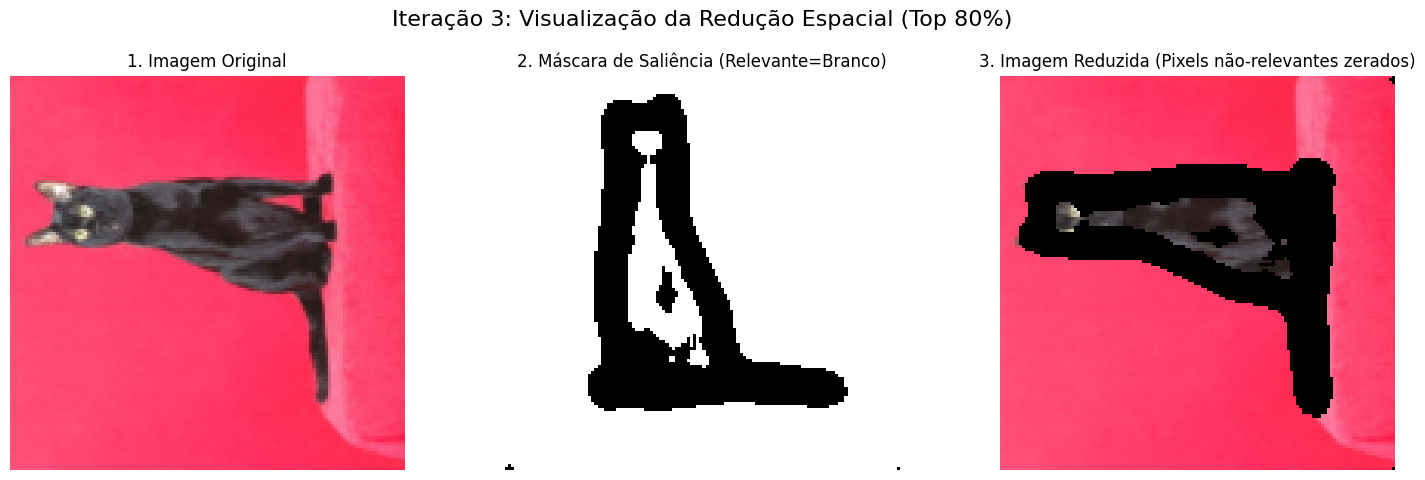

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 4.
--- Iteração 4 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.4870, LR: 0.000100
  Época 10/30, Perda Média: 0.4793, LR: 0.000100
  Época 15/30, Perda Média: 0.4685, LR: 0.000100
  Época 20/30, Perda Média: 0.4580, LR: 0.000100
  Época 25/30, Perda Média: 0.4617, LR: 0.000100
  Época 30/30, Perda Média: 0.4403, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.6919, mDice = 0.8171
 > Gerando máscara de saliência (Top 85% dos pixels relevantes).


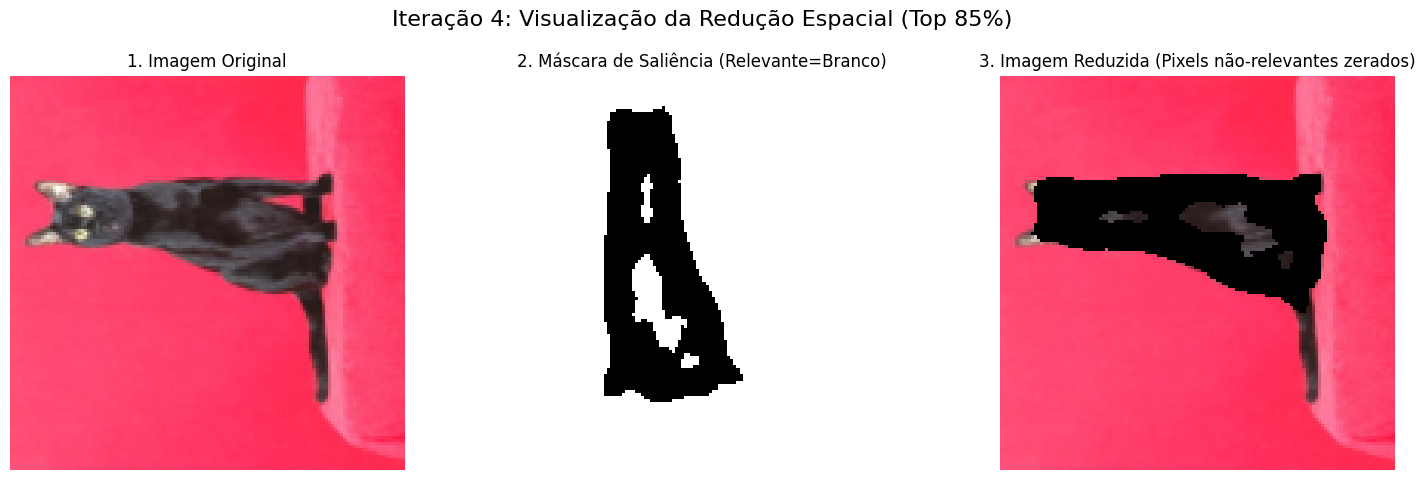

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 5.
--- Iteração 5 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.4411, LR: 0.000100
  Época 10/30, Perda Média: 0.4303, LR: 0.000100
  Época 15/30, Perda Média: 0.4201, LR: 0.000100
  Época 20/30, Perda Média: 0.4193, LR: 0.000100
  Época 25/30, Perda Média: 0.4053, LR: 0.000100
  Época 30/30, Perda Média: 0.3908, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7198, mDice = 0.8364
 > Gerando máscara de saliência (Top 90% dos pixels relevantes).


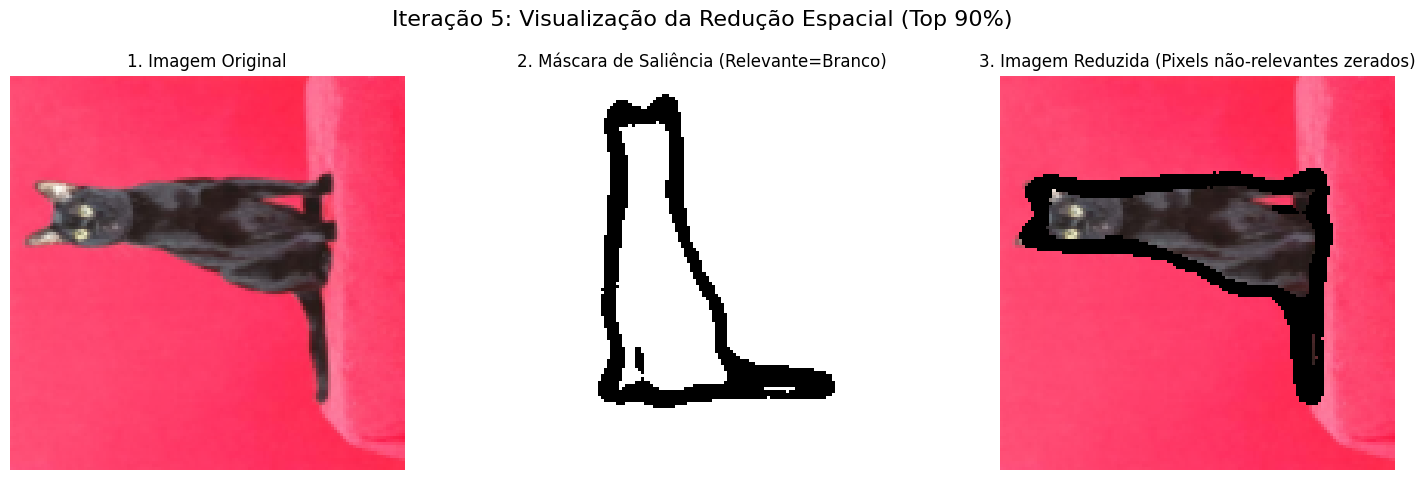

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 6.
--- Iteração 6 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.3887, LR: 0.000100
  Época 10/30, Perda Média: 0.3752, LR: 0.000100
  Época 15/30, Perda Média: 0.3757, LR: 0.000100
  Época 20/30, Perda Média: 0.3529, LR: 0.000100
  Época 25/30, Perda Média: 0.3661, LR: 0.000100
  Época 30/30, Perda Média: 0.3417, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7337, mDice = 0.8457
 > Gerando máscara de saliência (Top 95% dos pixels relevantes).


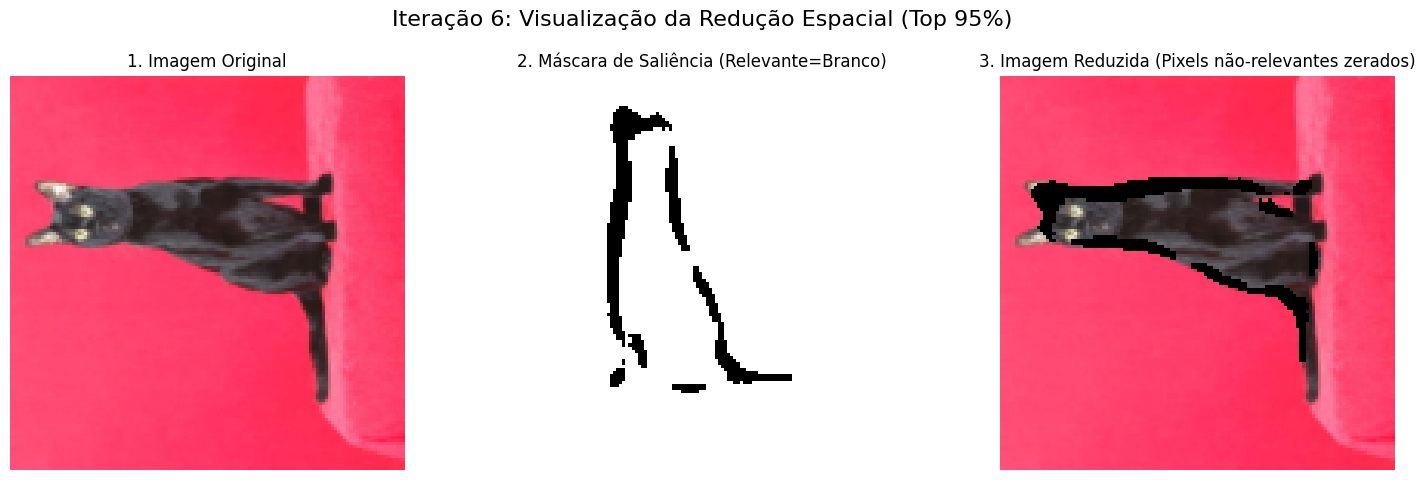

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 7.
--- Iteração 7 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.3444, LR: 0.000100
  Época 10/30, Perda Média: 0.3280, LR: 0.000100
  Época 15/30, Perda Média: 0.3294, LR: 0.000100
  Época 20/30, Perda Média: 0.3067, LR: 0.000100
  Época 25/30, Perda Média: 0.3008, LR: 0.000100
  Época 30/30, Perda Média: 0.3001, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7366, mDice = 0.8476
 > Gerando máscara de saliência (Top 100% dos pixels relevantes).


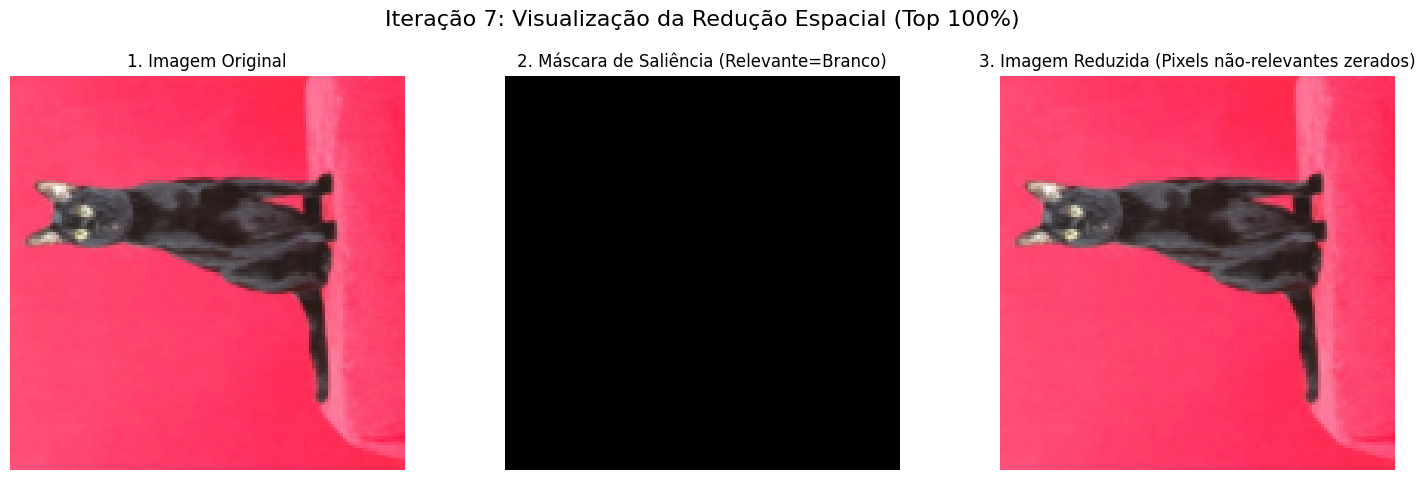

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 8.
--- Iteração 8 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.2959, LR: 0.000100
  Época 10/30, Perda Média: 0.2913, LR: 0.000100
  Época 15/30, Perda Média: 0.2670, LR: 0.000100
  Época 20/30, Perda Média: 0.2562, LR: 0.000100
  Época 25/30, Perda Média: 0.2493, LR: 0.000100
  Época 30/30, Perda Média: 0.2513, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7590, mDice = 0.8624
 > Gerando máscara de saliência (Top 105% dos pixels relevantes).


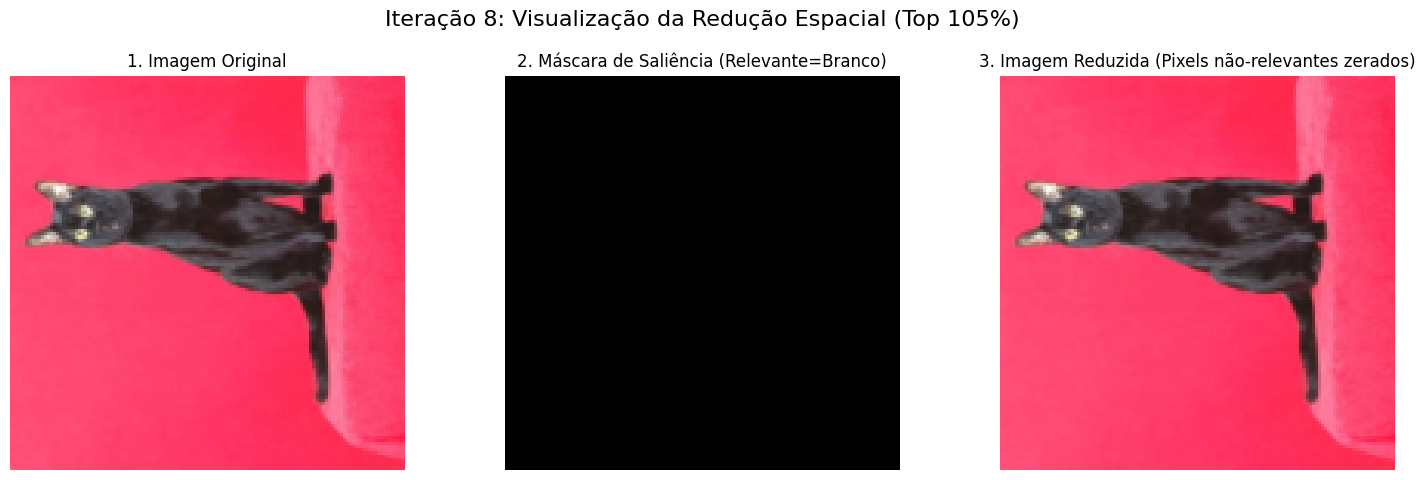

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 9.
--- Iteração 9 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.2268, LR: 0.000100
  Época 10/30, Perda Média: 0.2400, LR: 0.000100
  Época 15/30, Perda Média: 0.2128, LR: 0.000100
  Época 20/30, Perda Média: 0.2042, LR: 0.000100
  Época 25/30, Perda Média: 0.1931, LR: 0.000100
  Época 30/30, Perda Média: 0.1912, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7460, mDice = 0.8536
 > Gerando máscara de saliência (Top 110% dos pixels relevantes).


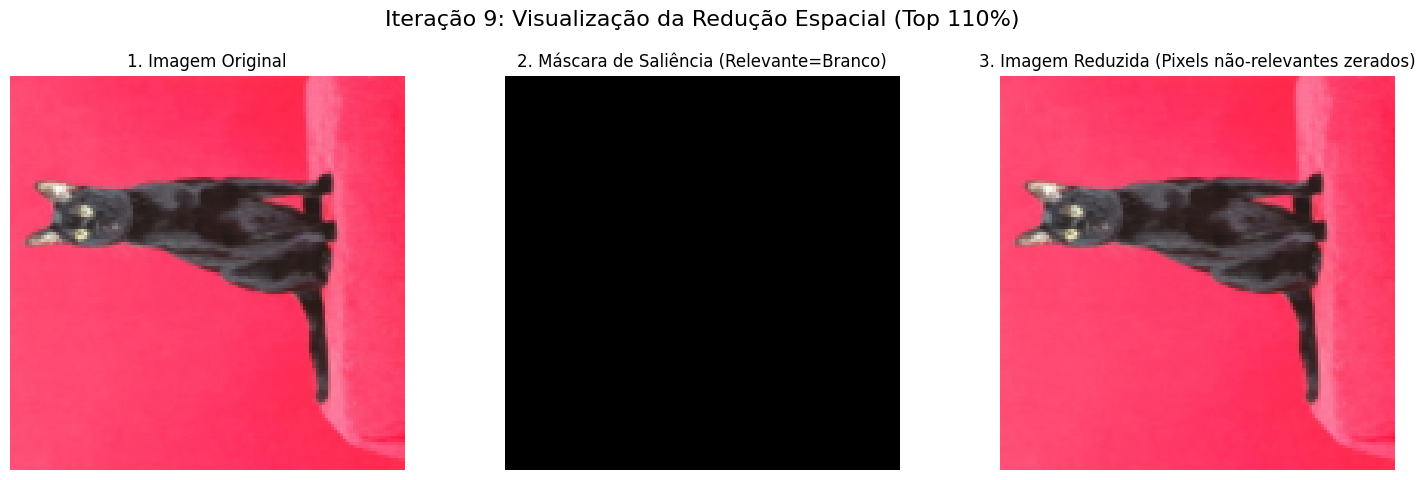

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 10.
--- Iteração 10 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.1791, LR: 0.000100
  Época 10/30, Perda Média: 0.1763, LR: 0.000100
  Época 15/30, Perda Média: 0.1673, LR: 0.000100
  Época 20/30, Perda Média: 0.1568, LR: 0.000050
  Época 25/30, Perda Média: 0.1421, LR: 0.000050
  Época 30/30, Perda Média: 0.1397, LR: 0.000050
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7535, mDice = 0.8587
 > Gerando máscara de saliência (Top 115% dos pixels relevantes).


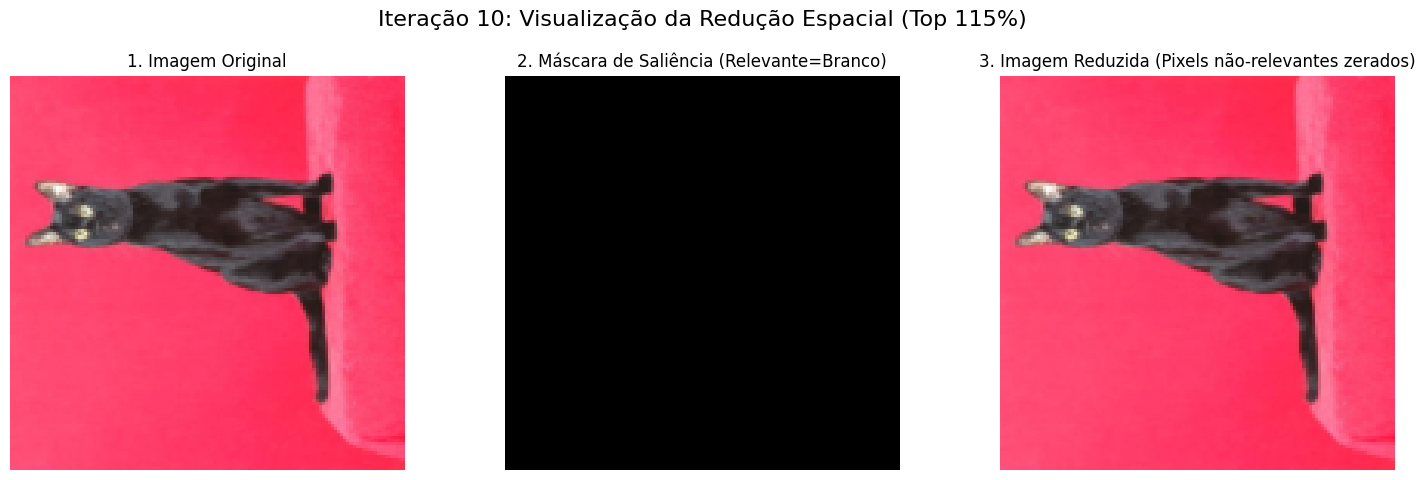

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 11.
--- Iteração 11 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.1433, LR: 0.000100
  Época 10/30, Perda Média: 0.1378, LR: 0.000100
  Época 15/30, Perda Média: 0.1484, LR: 0.000100
  Época 20/30, Perda Média: 0.1237, LR: 0.000050
  Época 25/30, Perda Média: 0.1204, LR: 0.000050
  Época 30/30, Perda Média: 0.1181, LR: 0.000050
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7566, mDice = 0.8608
 > Gerando máscara de saliência (Top 120% dos pixels relevantes).


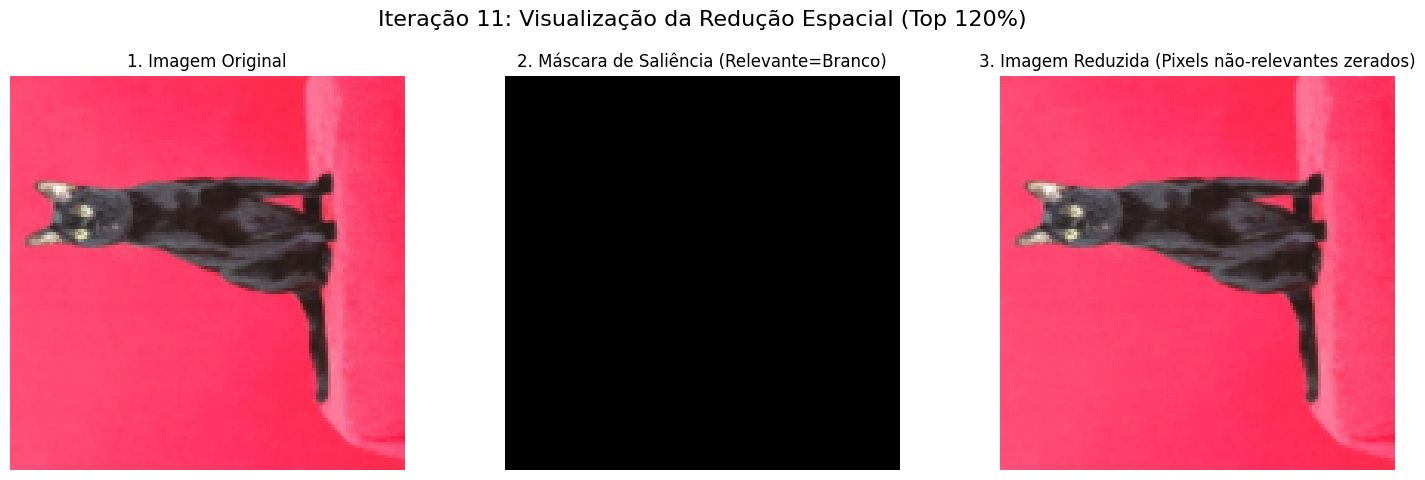

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 12.
--- Iteração 12 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.1560, LR: 0.000100
  Época 10/30, Perda Média: 0.1182, LR: 0.000100
  Época 15/30, Perda Média: 0.1141, LR: 0.000100
  Época 20/30, Perda Média: 0.1118, LR: 0.000100
  Época 25/30, Perda Média: 0.1133, LR: 0.000100
  Época 30/30, Perda Média: 0.1609, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7647, mDice = 0.8662
 > Gerando máscara de saliência (Top 125% dos pixels relevantes).


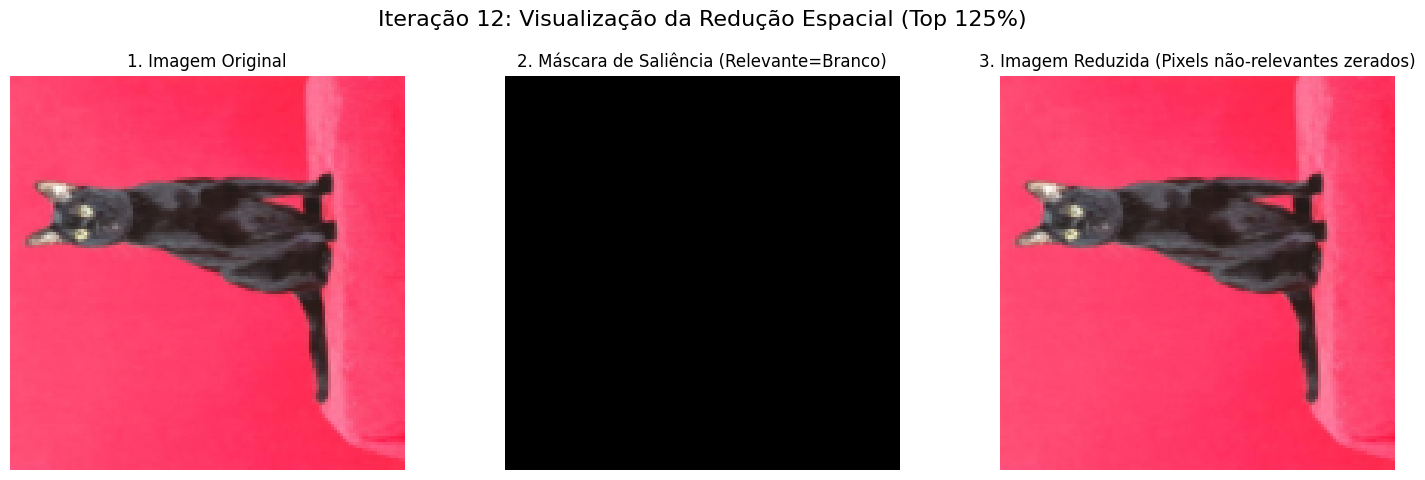

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 13.
--- Iteração 13 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.1126, LR: 0.000100
  Época 10/30, Perda Média: 0.1015, LR: 0.000100
  Época 15/30, Perda Média: 0.1120, LR: 0.000100
  Época 20/30, Perda Média: 0.0956, LR: 0.000100
  Época 25/30, Perda Média: 0.2770, LR: 0.000100
  Época 30/30, Perda Média: 0.0910, LR: 0.000050
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7545, mDice = 0.8594
 > Gerando máscara de saliência (Top 130% dos pixels relevantes).


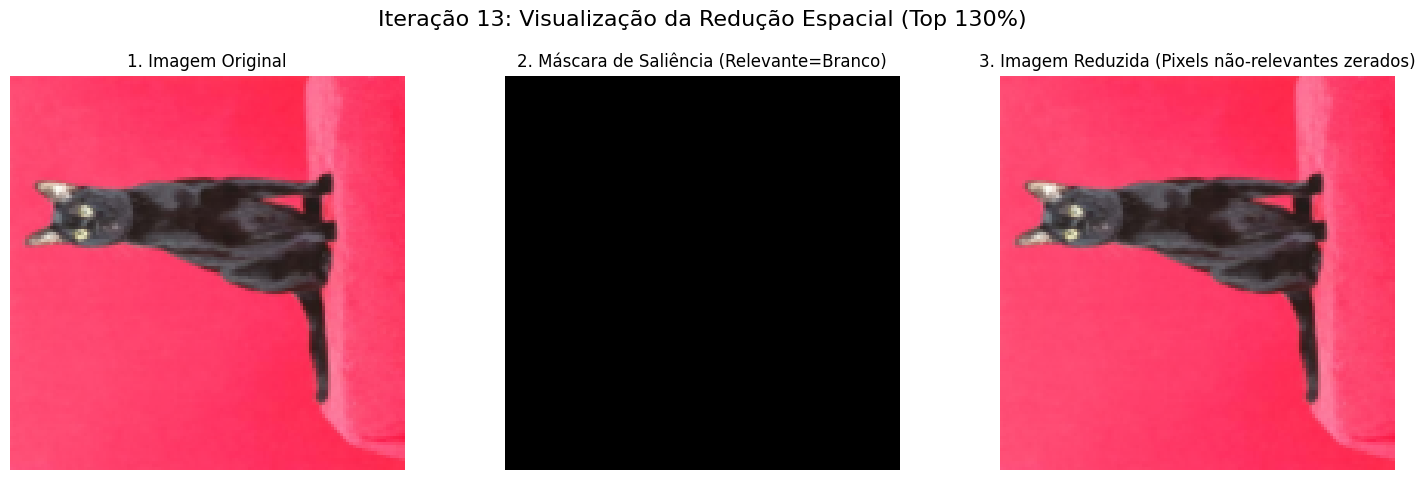

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 14.
--- Iteração 14 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.0918, LR: 0.000100
  Época 10/30, Perda Média: 0.1412, LR: 0.000100
  Época 15/30, Perda Média: 0.0867, LR: 0.000100
  Época 20/30, Perda Média: 0.1220, LR: 0.000100
  Época 25/30, Perda Média: 0.0870, LR: 0.000100
  Época 30/30, Perda Média: 0.1079, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7568, mDice = 0.8609
 > Gerando máscara de saliência (Top 135% dos pixels relevantes).


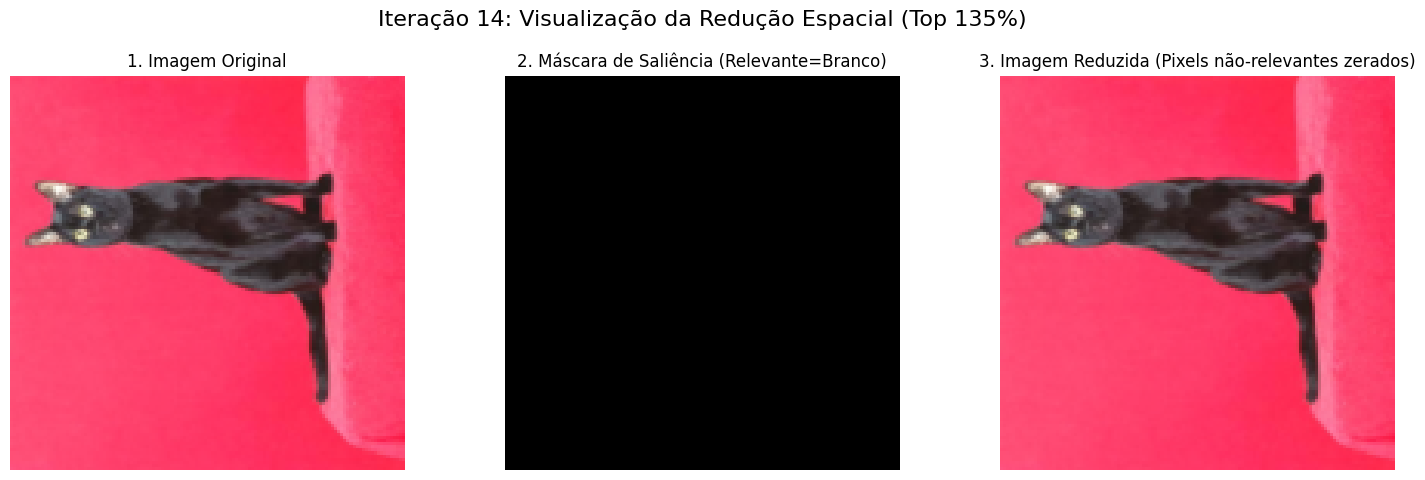

 > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração 15.
--- Iteração 15 ---
 > Treinando por 30 épocas...
  Época 5/30, Perda Média: 0.1136, LR: 0.000100
  Época 10/30, Perda Média: 0.0799, LR: 0.000100
  Época 15/30, Perda Média: 0.1089, LR: 0.000100
  Época 20/30, Perda Média: 0.0774, LR: 0.000100
  Época 25/30, Perda Média: 0.0757, LR: 0.000100
  Época 30/30, Perda Média: 0.1569, LR: 0.000100
 > MÉTRICAS DE VALIDAÇÃO (Final da Iteração): mIoU = 0.7559, mDice = 0.8603
 > Gerando máscara de saliência (Top 140% dos pixels relevantes).


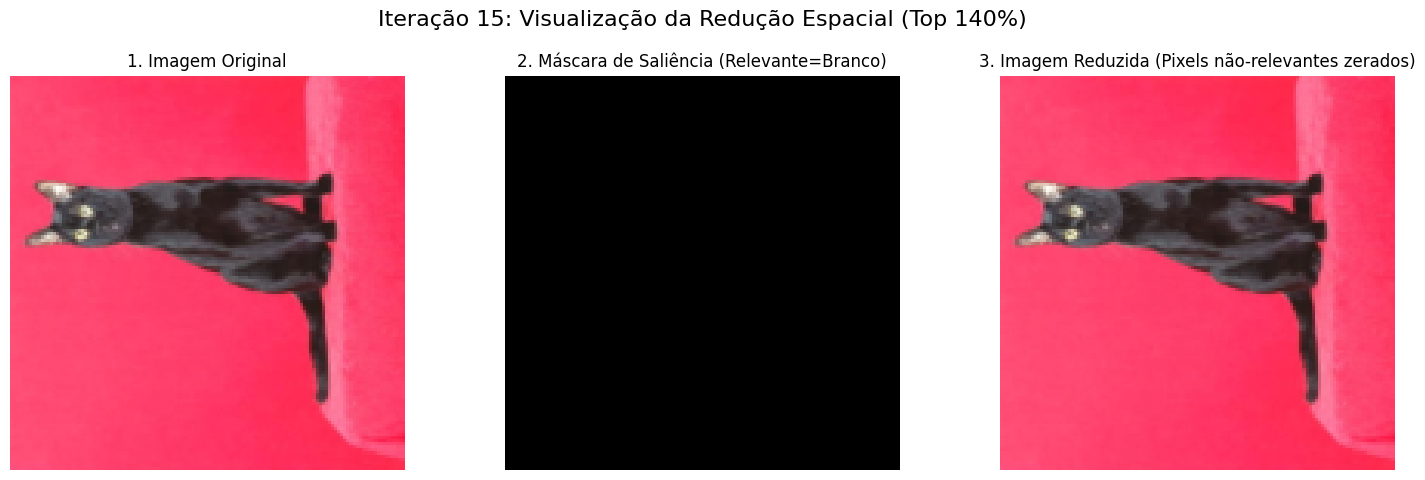


Ciclo Iterativo Concluído por atingir o número máximo de iterações.
That`s all folks


In [73]:

INPUT_SIZE = (128, 128)
NUM_CLASSES = 3 
BATCH_SIZE = 8
MAX_ITERATIONS = 15
threshold_percentile = 70 

train_loader, val_loader, test_loader = create_dataloaders(
    images_tar=r"C:\Users\joaov_zm1q2wh\python\etsai\themes\saliency_maps\code\data\unet\images.tar.gz",
    annotations_tar=r"C:\Users\joaov_zm1q2wh\python\etsai\themes\saliency_maps\code\data\unet\annotations.tar.gz",
    extract_dir=r"C:\Users\joaov_zm1q2wh\python\etsai\themes\saliency_maps\code\data\unet",
    input_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    augment=True,
    limit=1000 
)

X_train_orig_tensor, y_train_seg_index_tensor, X_train_orig_np, y_train_seg_index_np = get_full_train_data(train_loader, DEVICE)

X_train_current_np = X_train_orig_np.copy()
y_train_current_np = y_train_seg_index_np.copy()
criterion = nn.CrossEntropyLoss()
model = UNet(in_channels=3, num_classes=NUM_CLASSES).to(DEVICE)

print(f"\nIniciando Treinamento Iterativo (Max. {MAX_ITERATIONS} iterações) no {DEVICE}.\n")

for i in range(1, MAX_ITERATIONS + 1):
    print(f"--- Iteração {i} ---")
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    current_dataset = CustomReducedDataset(X_train_current_np, y_train_current_np)
    current_dataloader = DataLoader(current_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    model, m_iou, m_dice = train_iteration(
        model, current_dataloader, val_loader, optimizer, criterion, NUM_CLASSES, epochs=30
    )
    
    model.eval() 
    current_threshold = threshold_percentile + (i - 1) * 5
    print(f" > Gerando máscara de saliência (Top {current_threshold}% dos pixels relevantes).")
    
    with torch.no_grad():
        y_pred_seg = model(X_train_orig_tensor) 
    
    masks_tensor = create_saliency_mask(y_pred_seg, current_threshold)
    X_train_next_tensor = apply_mask(X_train_orig_tensor, masks_tensor)
    X_train_current_np = X_train_next_tensor.permute(0, 2, 3, 1).cpu().numpy()
    
    visualize_saliency_and_reduction(
        original_img_np=X_train_orig_np, 
        mask_tensor=masks_tensor, 
        reduced_img_np=X_train_current_np, 
        iteration=i
    )
    
    if i == MAX_ITERATIONS:
        print('\nCiclo Iterativo Concluído por atingir o número máximo de iterações.')
        break
        
    print(f' > Dados de treinamento atualizados (redução espacial). Preparando para a Iteração {i+1}.')

print('That`s all folks')